# Figure 2 

Results averaged across 100 ensemble members. A) average bias between the neural-network reconstruction and model truth. B) number of months with observations over the 1982-2016 reconstruction period.  C) cross plot of the number of months with data and the average bias with color representing the decadal correlation between the reconstruction and model truth. 

In [20]:
%matplotlib inline
%config InlineBackend.figure_format = 'png'
%config InlineBackend.print_figure_kwargs = {'dpi':300, 'bbox_inches': 'tight'}
import numpy as np
import pandas as pd
import xarray as xr
import seaborn as sns
import xarray.ufuncs as xu
import cmocean as cm
from scipy import stats
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.ticker import AutoMinorLocator
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import os

In [21]:
%run _define_model_class.ipynb
%run _define_plotting_class.ipynb

In [22]:
dir_raw = '/local/data/artemis/workspace/gloege/SOCAT-LE/data/raw/'
dir_clean = '/local/data/artemis/workspace/gloege/SOCAT-LE/data/clean/'
dir_figs = '/local/data/artemis/workspace/gloege/SOCAT-LE/results/figures_MS'

### SOCAT directory
#data_dir = f'{dir_raw}SOCAT'

# Load data

In [23]:
reconstruction='SOMFFN'
ds = xr.open_dataset(f'{dir_raw}SOCAT/SOCATv5_tracks_gridded_monthly.nc')
ds_mask = xr.open_dataset(f'{dir_raw}SOCAT/SOCATv5_mask_198201-201701.nc')
#ds_stats = xr.open_dataset(f'{dir_clean}statistics_SOMFFN_CESM.nc')
ds_stats = xr.open_mfdataset(f'{dir_clean}/CO2_flux_stats/stats_FCO2_*_SOMFFN.nc', 
                             combine='nested', 
                             concat_dim='ensemble')

In [24]:
ds_mask = ds_mask.rename({'xlon':'lon', 'ylat':'lat'})
ds = ds.rename({'xlon':'lon', 'ylat':'lat'})

In [25]:
nobs = ds['count_nobs'].loc['1982-01':'2016-12'].roll(lon=-180, roll_coords='lon').sum(dim='tmnth')
#nmonths = ds_mask['socat_mask'][:-1,:,:].sum(dim='time')

nmonths = (ds['FCO2_AVE_UNWTD'].where((ds['tmnth.year']>=1982),drop=True).\
           where((ds['tmnth.year']<=2016)) >0).sum('tmnth')
nmonths = nmonths.roll(lon=180)
nmonths['lon'] = ds_stats['lon']
nmonths = nmonths.where(nmonths>0)

/home/gloege/.conda/envs/tensorflow/lib/python3.7/site-packages/xarray/core/dataarray.py:2710: FutureWarning: roll_coords will be set to False in the future. Explicitly set roll_coords to silence warning.
  shifts=shifts, roll_coords=roll_coords, **shifts_kwargs


In [26]:
nmonths.mean()

<xarray.DataArray 'FCO2_AVE_UNWTD' ()>
array(8.82229179)

# A. Bias

In [80]:
data = ds_stats['bias'].mean('ensemble')

In [87]:
data.sel(lat=slice(0,90)).stack(z=['lat','lon']).dropna('z').to_dataframe().describe()

/home/gloege/.conda/envs/tensorflow/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/gloege/.conda/envs/tensorflow/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


,bias
count,12225.000000
mean,0.011466
std,0.141289
min,-1.393407
25%,-0.054670
50%,-0.002631
75%,0.059470
max,1.832879


In [88]:
data.sel(lat=slice(-90,0)).stack(z=['lat','lon']).dropna('z').to_dataframe().describe()

/home/gloege/.conda/envs/tensorflow/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/gloege/.conda/envs/tensorflow/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


,bias
count,21551.000000
mean,-0.043555
std,0.172884
min,-4.246063
25%,-0.134046
50%,-0.028122
75%,0.059777
max,0.647835


In [63]:
np.percentile(data,75)
np.std(np.abs(data))

0.12289349866804992

/home/gloege/.conda/envs/tensorflow/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


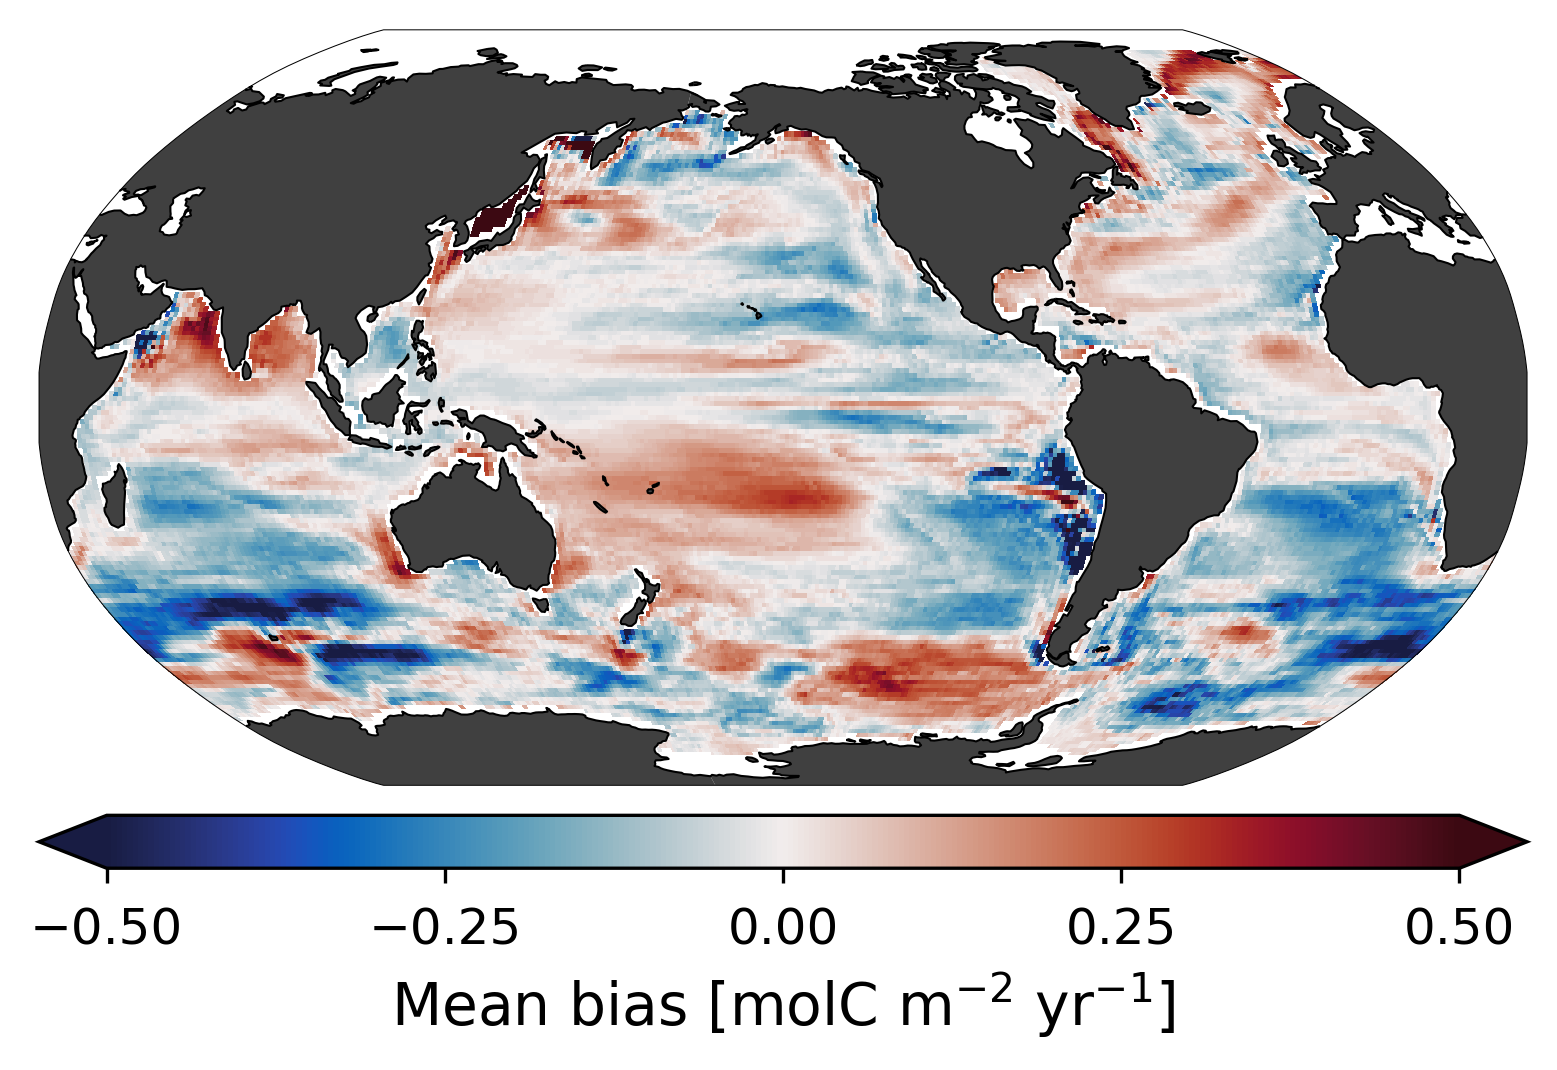

In [158]:
plot_style = 'seaborn-paper'

with plt.style.context(plot_style):
    # Setup Figure
    fig = plt.figure(dpi=300) 
    worldmap = SpatialMap2(fig=fig, region='world', 
                   cbar_mode='each',
                   colorbar=True,
                   cbar_location='bottom',
                   nrows_ncols=[1,1])
    
    
    # Colorbar ranges
    vrange = [-0.5, 0.5, 0.25]
    cmap = cm.cm.balance
    
    ##-----------------------------------------------------
    ## Ensemble mean
    ##-----------------------------------------------------
    # Bias
    data = (ds_stats['bias']*1).mean('ensemble')
    data = xr_add_cyclic_point(data, cyclic_coord='lon') 
    sub = worldmap.add_plot(lon=data['lon'], lat=data['lat'], data=data, 
                      vrange=vrange[0:2], cmap=cm.cm.balance, ax=0, linewidth_coast=0.5)
    
    #worldmap.set_title(f'SOMFFN/{model}', ax=0)
    # add colorbar
    col = worldmap.add_colorbar(sub, ax=0,extend='both')
    worldmap.set_cbar_xlabel(col, 'Mean bias [molC m$^{-2}$ yr$^{-1}$]', fontsize=14)
    worldmap.set_ticks(col, vrange[0], vrange[1], vrange[2])
    #col.ax.set_xticklabels([vrange[0], vrange[1], vrange[2]])
    col.ax.tick_params(labelsize=12)
#fig.savefig(f'{dir_figs}/bias_map.pdf',bbox_inches='tight', dpi=300, pad_inches=0)

## Mean bias

In [57]:
data = (ds_stats['bias']*1).mean('ensemble')
print(f"mean bias: {data.mean(['lat','lon']).values}")

mean bias: -0.02364063920093855


/home/gloege/.conda/envs/tensorflow/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


## 90th percentile
The value below which 90% of the observations may be found 

In [161]:
numberOfMonths = 48
percentile = 90
out =ds_stats['bias'].mean('ensemble').where(nmonths>numberOfMonths).stack(z=('lat','lon')).dropna(dim='z')
print(f"90th percentile given 48th months of obs : {np.percentile(np.abs(out).values, percentile)}")

90th percentile given 48th months of obs : 0.1427548609149611


/home/gloege/.conda/envs/tensorflow/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/gloege/.conda/envs/tensorflow/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


## Counter observations given months with data

In [77]:
monthRange=[96, 300]
(nmonths.where((nmonths>24) & (nmonths<=96))>0).sum()

<xarray.DataArray 'FCO2_AVE_UNWTD' ()>
array(2232)

## Statiatics

In [119]:
# select correspnding locations
bias_mean = ds_stats['bias'].mean('ensemble')
bias_mean = bias_mean.where((nmonths>0) & (bias_mean>0))
nmonths_tmp= nmonths.where((nmonths>0) & (bias_mean>0))
# flatten
nmonths_flat = nmonths_tmp.stack(z=('lon','lat')).dropna('z')
bias_flat = bias_mean.stack(z=('lon','lat')).dropna('z')
# correlations
np.corrcoef(np.abs(bias_flat.values), nmonths_flat.values)

/home/gloege/.conda/envs/tensorflow/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/gloege/.conda/envs/tensorflow/lib/python3.7/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in greater
  return func(*args2)
/home/gloege/.conda/envs/tensorflow/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/gloege/.conda/envs/tensorflow/lib/python3.7/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in greater
  return func(*args2)
/home/gloege/.conda/envs/tensorflow/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/gloege/.conda/envs/tensorflow/lib/python3.7/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in greater
  return

array([[ 1.        , -0.08581777],
       [-0.08581777,  1.        ]])

## distribution

In [127]:
data = ds_stats['bias'].mean('ensemble').stack(z=('lon','lat')).dropna('z')

/home/gloege/.conda/envs/tensorflow/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


/home/gloege/.conda/envs/tensorflow/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


(-2, 2)

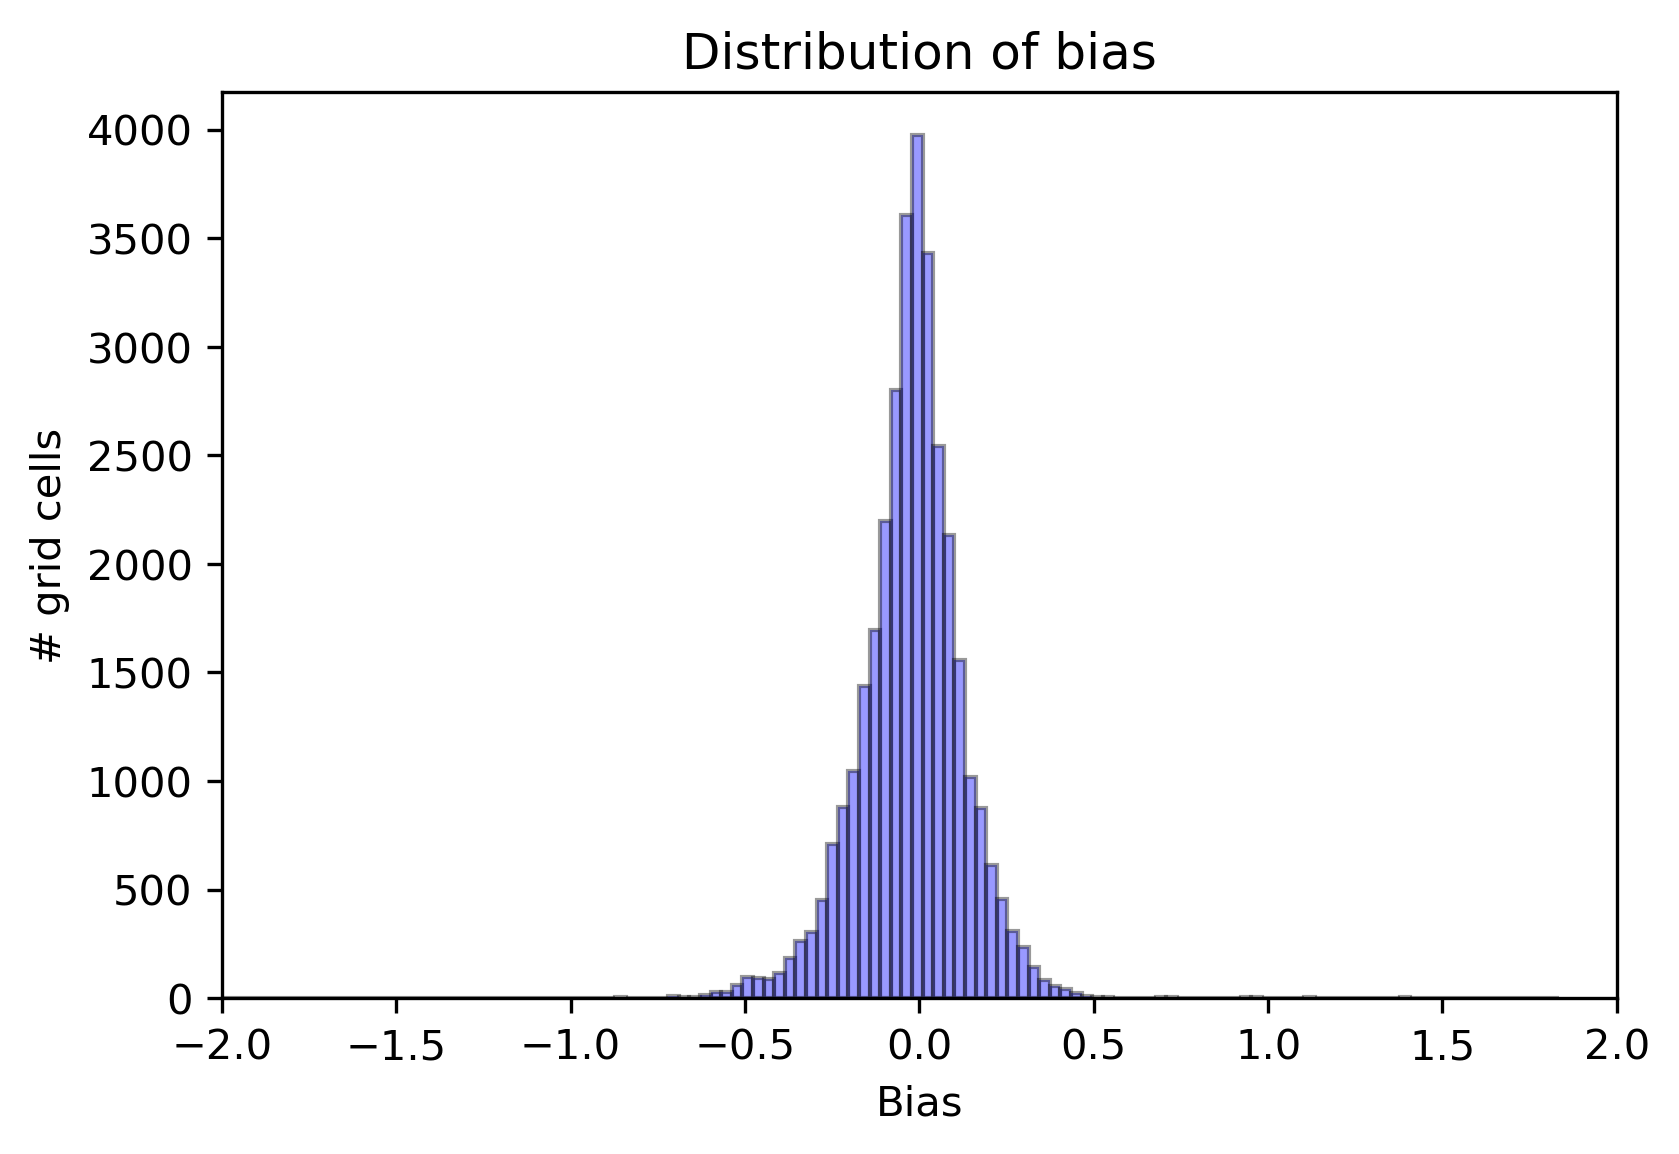

In [157]:
# Import the libraries
import matplotlib.pyplot as plt
import seaborn as sns

# seaborn histogram
sns.distplot(data, hist=True, kde=False, 
             bins=200, color = 'blue',
             hist_kws={'edgecolor':'black'})
# Add labels
plt.title('Distribution of bias')
plt.xlabel('Bias')
plt.ylabel('# grid cells')
plt.xlim([-2,2])

# B. Number obs

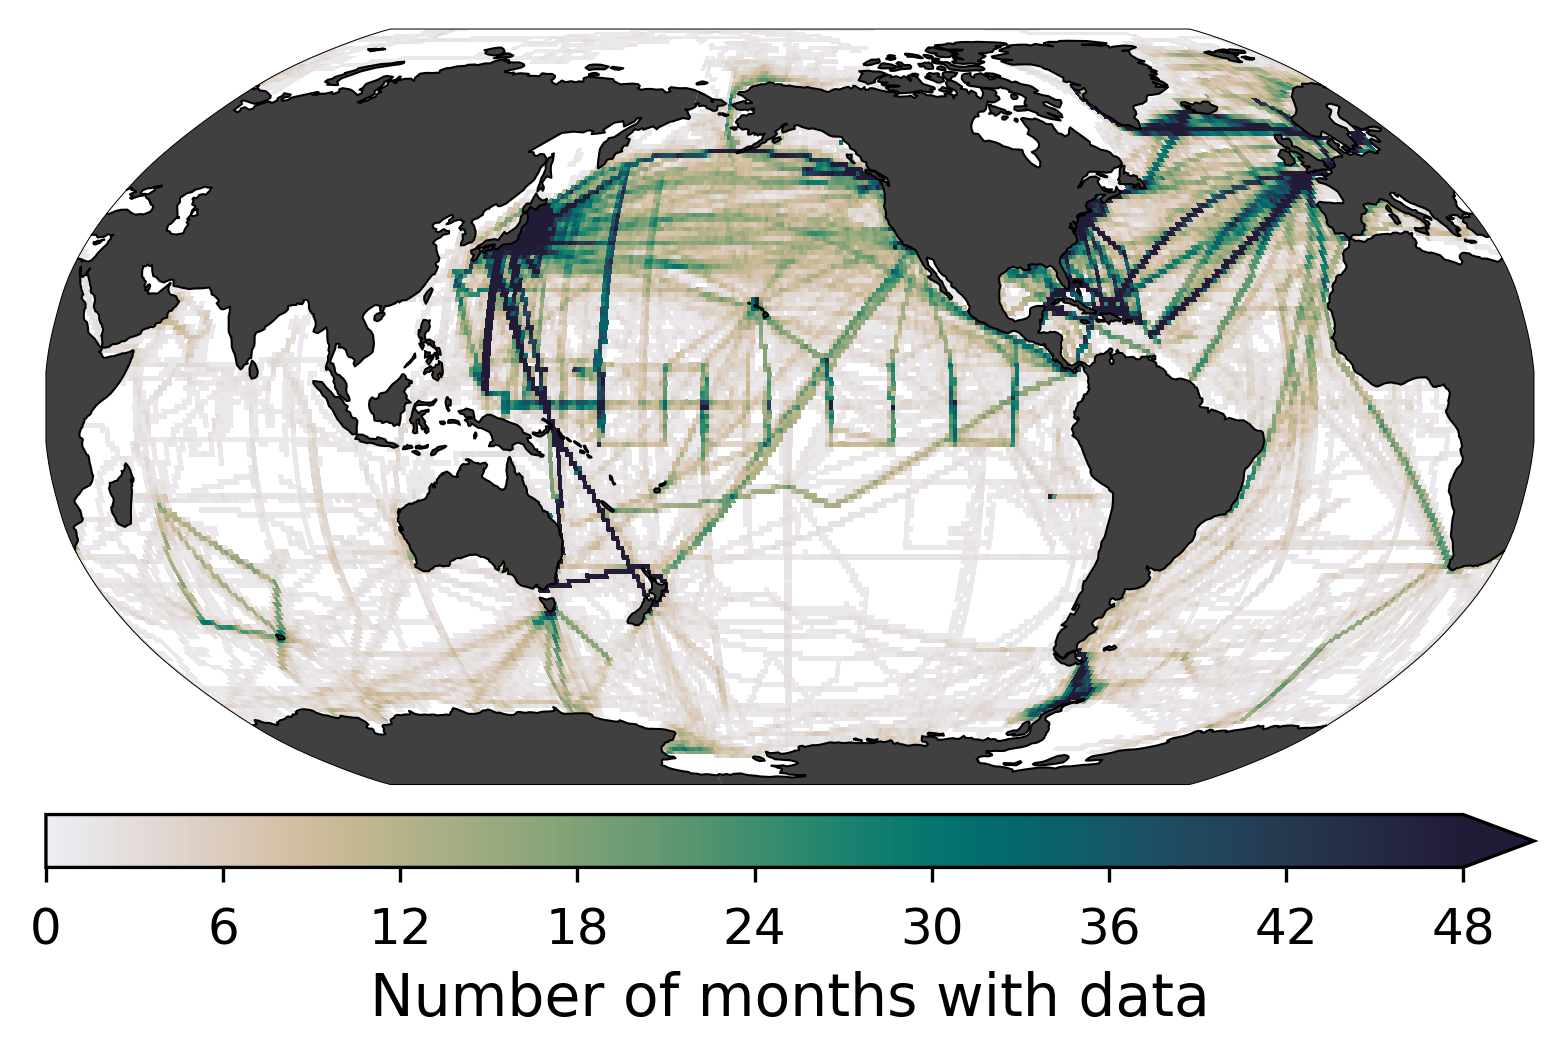

In [160]:
plot_style = 'seaborn-paper'

with plt.style.context(plot_style):
    # Setup Figure
    fig = plt.figure(dpi=300) 
    worldmap = SpatialMap2(fig=fig, region='world', 
                   cbar_mode='each',
                   colorbar=True,
                   cbar_location='bottom',
                   nrows_ncols=[1,1])
    
    
    # Colorbar ranges
    vrange = [0, 48, 6]
    #cmap = cm.cm.balance
    cmap = cm.cm.rain
    data = xr_add_cyclic_point(nmonths, cyclic_coord='lon')
    
    sub = worldmap.add_plot(lon=data['lon'], lat=data['lat'], data=data, 
                      vrange=vrange[0:2], cmap=cmap, ax=0, linewidth_coast=0.5)
    
    #worldmap.set_title(f'SOMFFN/{model}', ax=0)
    # add colorbar
    col = worldmap.add_colorbar(sub, ax=0,extend='max')
    worldmap.set_cbar_xlabel(col, 'Number of months with data', fontsize=14)
    worldmap.set_ticks(col, vrange[0], vrange[1], vrange[2])
    col.ax.tick_params(labelsize=12)
    #col.set_label_text(['','','','','','','',''])
    #col.ax.set_xticklabels(['0','24','','72','','120','','168'])
    #col.ax.set_xticklabels(clevs1[::1],rotation=90)
#fig.savefig(f'{dir_figs}/months-with-measurements.pdf',bbox_inches='tight', dpi=300, pad_inches=0)

# C. Skill vs obs

/home/gloege/.conda/envs/tensorflow/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/gloege/.conda/envs/tensorflow/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/gloege/.conda/envs/tensorflow/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/gloege/.conda/envs/tensorflow/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/gloege/.conda/envs/tensorflow/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/gloege/.conda/envs/tensorflow/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: 

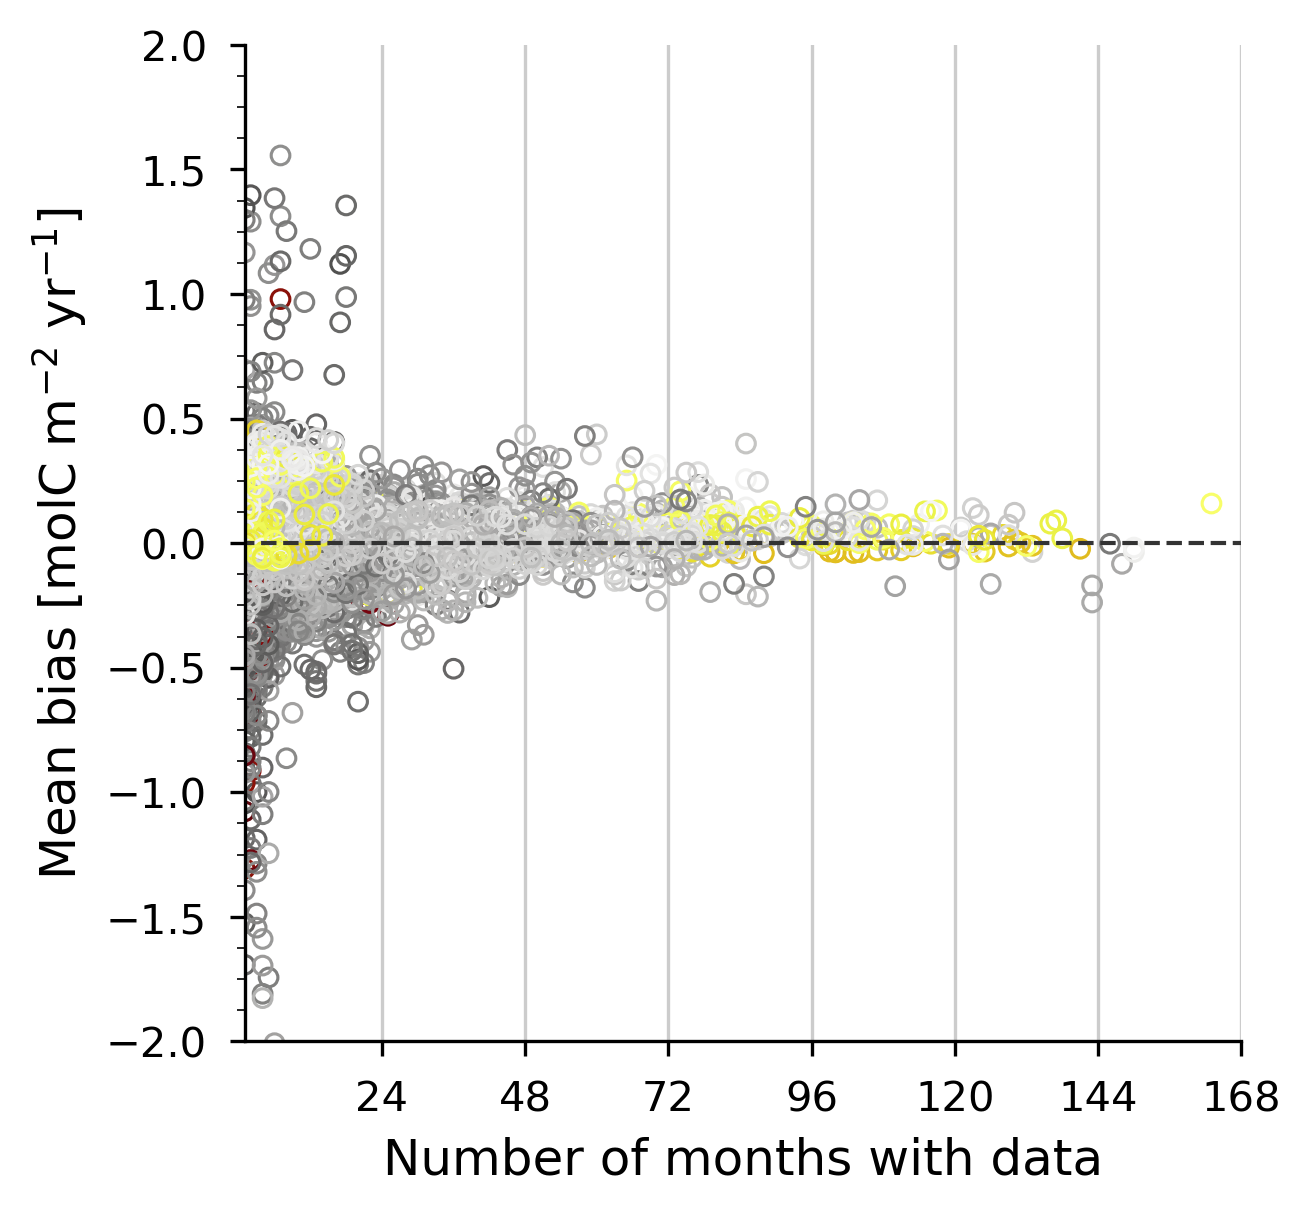

In [159]:
plot_style = 'seaborn-paper'

with plt.style.context(plot_style):
    fig = plt.figure(dpi=300) 
    ax = fig.add_subplot(111)
    cmap = plt.cm.nipy_spectral
    cmap = cm.cm.oxy
    
    ## ------------------------------------
    ## Define data variables
    ## -----------------------------------
    corr_dec = ds_stats['corr_dec'].mean(dim='ensemble')
    aae = ds_stats['aae'].mean(dim='ensemble')
    bias = ds_stats['bias'].mean(dim='ensemble')
    lat = ds_stats['lat']

    ## ------------------------------------
    ## 0 reference line
    ## -----------------------------------
    ax.plot([0,168],[0,0],'--',color=[0.2, 0.2, 0.2], linewidth=1)
    
    sub = ax.scatter(nmonths, bias, s=20,
                     c=corr_dec, cmap=cmap, vmin=0, vmax=1, 
                     linewidth=0.75, marker='o') 
    sub.set_facecolor("none")

    ## ------------------------------------
    ## axis limits and labels
    ## -----------------------------------
    ax.set_xlim(1,168)
    ax.set_xticks(np.arange(24, 170,24))
    ax.set_ylim(-2,2)
    # fongsize was 20
    ax.set_xlabel('Number of months with data', fontsize=12)
    ax.set_ylabel('Mean bias [molC m$^{-2}$ yr$^{-1}$]', fontsize=12)
    ax.xaxis.set_tick_params(labelsize=10)
    ax.yaxis.set_tick_params(labelsize=10)

    
    ## ------------------------------------
    ## Modify axes
    ## -----------------------------------
    # Turn on the minor ticks
    # Turn off the display of all ticks.
    ax.tick_params(which='both', # Options for both major and minor ticks
                    top='off', # turn off top ticks
                    left='off', # turn off left ticks
                    right='off',  # turn off right ticks
                    bottom='off') # turn off bottom ticks


    ### Hide the right and top spines
    ax.spines['right'].set_visible(False)
    #ax.spines['left'].set_visible(False)
    ax.spines['top'].set_visible(False)
    #ax.spines['bottom'].set_visible(False)

    ### major / minor tick lines
    #ax.minorticks_on()
    ax.yaxis.set_minor_locator(AutoMinorLocator(4))
    #ax.grid(axis='y', which='major', color=[0.8,0.8,0.8], linestyle='-')

    ### Only show ticks on the left and bottom spines
    ax.yaxis.set_ticks_position('left')
    ax.xaxis.set_ticks_position('bottom')

    ## ------------------------------------
    ## Make plot square 
    ## and add grid lines
    ## -----------------------------------
    x0,x1 = ax.get_xlim()
    y0,y1 = ax.get_ylim()
    ax.set_aspect(abs(x1-x0)/abs(y1-y0))
    ax.get_position().bounds
    ax.grid(axis='x', which='major', color=[0.8,0.8,0.8], linestyle='-')

    # Don't allow the axis to be on top of your data
    ax.set_axisbelow(True)

#fig.savefig(f'{dir_figs}/bias_vs_nobs.pdf',bbox_inches='tight', dpi=300, pad_inches=0)

# C. Stand alone colorbar
https://matplotlib.org/examples/api/colorbar_only.html

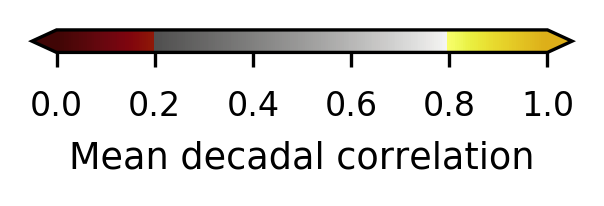

In [35]:
plot_style = 'seaborn-paper'

with plt.style.context(plot_style):
    fig = plt.figure(figsize=(2, 0.5))
    ax = fig.add_axes([0.05, 0.80, 0.9, 0.15])
    cmap = cm.cm.oxy
    norm = mpl.colors.Normalize(vmin=0, vmax=1)
    col = mpl.colorbar.ColorbarBase(ax, cmap=cmap,
                                    norm=norm,
                                    orientation='horizontal', 
                                    extend='both')
    col.ax.set_xlabel('Mean decadal correlation')
    col.set_ticks(np.arange(0,1.1,0.2))